In [4]:
import io
import requests
import zipfile
import warnings
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from giskard import Dataset, Model, testing, Suite
from sklearn.linear_model import LinearRegression

warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
url = "https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip"
content = requests.get(url).content
with zipfile.ZipFile(io.BytesIO(content)) as handle:
    raw_data = pd.read_csv(handle.open('day.csv'), header=0, sep=',', parse_dates=['dteday'])

In [10]:
# For simplicity we'll be using two categorical features, three numeric features and the target variable

CAT_COLS = ['holiday', 'weathersit']
NUM_COLS = ['temp', 'atemp', 'windspeed']
TARGET_COL = 'cnt'

raw_data = raw_data[CAT_COLS + NUM_COLS + [TARGET_COL]]
raw_data.head()

,holiday,weathersit,temp,atemp,windspeed,cnt
0,0,2,0.344167,0.363625,0.160446,985
1,0,2,0.363478,0.353739,0.248539,801
2,0,1,0.196364,0.189405,0.248309,1349
3,0,1,0.200000,0.212122,0.160296,1562
4,0,1,0.226957,0.229270,0.186900,1600


In [11]:
def _check_test(col_type: str, 
                column_name: str, 
                num_rows: int, 
                prediction_flag: bool = False, 
                NUM_ROWS_THRESHOLD: int = 1000):
    
    is_small_dataset = num_rows <= NUM_ROWS_THRESHOLD
    drift_test_function = None

    if col_type == 'numeric':
        if is_small_dataset:
            drift_test_function = testing.test_drift_prediction_ks if prediction_flag else testing.test_drift_ks
        else:
            drift_test_function = testing.test_drift_prediction_earth_movers_distance if prediction_flag else testing.test_drift_earth_movers_distance

    elif col_type == 'categorical':
        if is_small_dataset:
            drift_test_function = testing.test_drift_prediction_psi if prediction_flag else testing.test_drift_psi
        else:
            drift_test_function = testing.test_drift_prediction_chi_square if prediction_flag else testing.test_drift_chi_square

    if drift_test_function:
        return drift_test_function(column_name=column_name)

    raise ValueError(f"Unsupported column type: {col_type}")

In [12]:
def test_drift_dataset_suite(suite_name: str,
                             cols: list,
                             wrapped_ref_dataset: Dataset,
                             prediction_col_type: str = None,
                             prediction_col: str = None):
    N = len(wrapped_ref_dataset.df)

    suite = Suite(name=suite_name)

    for col in cols:
        if col in wrapped_ref_dataset.category_features.keys():
            test = _check_test('categorical', col, N)
        else:
            test = _check_test('numeric', col, N)
        
        suite.add_test(test)

    if prediction_col is not None:
        test = _check_test(prediction_col_type, prediction_col, N, True)
        suite.add_test(test)

    return suite

In [20]:
def dataset_drift_test(test_suite_results: list,
                       threshold: float = 0.5):

    raw_results = test_suite_results
    count, N = 0, len(raw_results)

    for result in raw_results:
        if 'succeed' in str(result[1]): count += 1
    passed = (count / N) > threshold

    return {
        'passed': passed,
        'metric': (count / N)
    }

In [19]:
reference_data = raw_data.iloc[:100]
current_data = raw_data.iloc[100:200]

In [21]:
lr = LinearRegression()

lr.fit(reference_data.drop('cnt', axis=1), reference_data.cnt)

def prediction_function(df):
    return lr.predict(df)

giskard_model = Model(
    model=prediction_function,
    model_type="regression"
)

In [22]:
wrapped_ref_dataset = Dataset(
    reference_data,
    cat_columns=CAT_COLS,
    target=TARGET_COL
)

wrapped_curr_dataset = Dataset(
    current_data,
    cat_columns=CAT_COLS,
    target=TARGET_COL
)

## Test Suite for all Features and Target Variable

In [24]:
features_target_drift_suite = test_drift_dataset_suite(
    suite_name='all_features_drift_test',
    cols=CAT_COLS + NUM_COLS,
    wrapped_ref_dataset = wrapped_ref_dataset,
    prediction_col_type = 'numeric',
    prediction_col = TARGET_COL
)

features_target_drift_suite_result = features_target_drift_suite.run(actual_dataset=wrapped_curr_dataset,
                                                                     reference_dataset=wrapped_ref_dataset,
                                                                     model=giskard_model)
features_target_drift_suite_result

Executed 'Categorical drift (PSI)' with arguments {'actual_dataset': <giskard.datasets.base.Dataset object at 0x7f9ba9ce2670>, 'reference_dataset': <giskard.datasets.base.Dataset object at 0x7f9b89a99610>, 'column_name': 'holiday'}: 
               Test succeeded
               Metric: 0.0
                - [TestMessageLevel.ERROR] The data is drifting for the following modalities: [,1,]
               
Executed 'Categorical drift (PSI)' with arguments {'actual_dataset': <giskard.datasets.base.Dataset object at 0x7f9ba9ce2670>, 'reference_dataset': <giskard.datasets.base.Dataset object at 0x7f9b89a99610>, 'column_name': 'weathersit'}: 
               Test succeeded
               Metric: 0.05
                - [TestMessageLevel.ERROR] The data is drifting for the following modalities: [,1,,, ,2,,, ,3,]
               
Executed 'Numerical drift (Kolmogorov-Smirnov)' with arguments {'actual_dataset': <giskard.datasets.base.Dataset object at 0x7f9ba9ce2670>, 'reference_dataset': <giskard.

<TestSuiteResult (failed)>

In [39]:
for result in features_target_drift_suite_result.results[:-1]:
    print(result[1].metric, result[2]['column_name'])

# For target: No column name
features_target_drift_suite_result.results[-1][1].metric

0.004157216082753533 holiday
0.04863259093595293 weathersit
1.2170049699100436e-45 temp
1.2170049699100436e-45 atemp
0.03638428787491733 windspeed


1.9509242595079607e-39

## Test Suite at Dataset Level

In [41]:
dataset_drift_test(features_target_drift_suite_result.results)

{'passed': False, 'metric': 0.5}

## Test Suite for Important Features

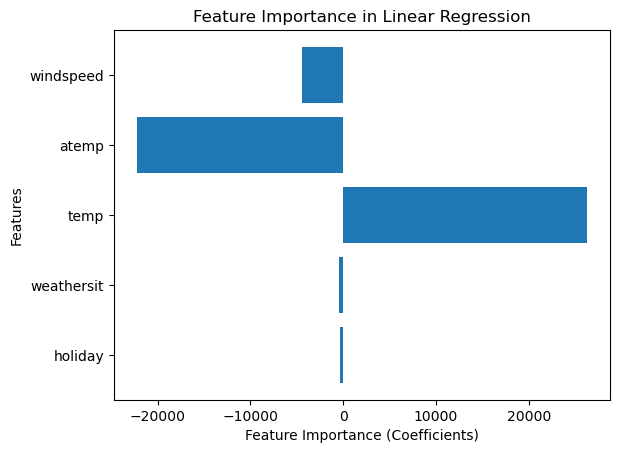

In [42]:
cols = list(reference_data.drop('cnt', axis=1).columns)
plt.barh(cols, lr.coef_)
plt.xlabel('Feature Importance (Coefficients)')
plt.ylabel('Features')
plt.title('Feature Importance in Linear Regression')
plt.show()

In [44]:
important_features = ['temp', 'atemp', 'windspeed']
imp_features_drift_suite = test_drift_dataset_suite('important_features_drift_test',
                                                    important_features,
                                                    wrapped_ref_dataset)

imp_features_drift_suite_results = imp_features_drift_suite.run(actual_dataset=wrapped_curr_dataset,
                                                                reference_dataset=wrapped_ref_dataset)
imp_features_drift_suite_results

Executed 'Numerical drift (Kolmogorov-Smirnov)' with arguments {'actual_dataset': <giskard.datasets.base.Dataset object at 0x7f9ba9ce2670>, 'reference_dataset': <giskard.datasets.base.Dataset object at 0x7f9b89a99610>, 'column_name': 'temp'}: 
               Test failed
               Metric: 0.0
                - [TestMessageLevel.ERROR] The data is drifting (p-value is equal to 0.0 and is below the test risk level 0.05) 
               
Executed 'Numerical drift (Kolmogorov-Smirnov)' with arguments {'actual_dataset': <giskard.datasets.base.Dataset object at 0x7f9ba9ce2670>, 'reference_dataset': <giskard.datasets.base.Dataset object at 0x7f9b89a99610>, 'column_name': 'atemp'}: 
               Test failed
               Metric: 0.0
                - [TestMessageLevel.ERROR] The data is drifting (p-value is equal to 0.0 and is below the test risk level 0.05) 
               
Executed 'Numerical drift (Kolmogorov-Smirnov)' with arguments {'actual_dataset': <giskard.datasets.base.Dataset 

<TestSuiteResult (failed)>

In [45]:
dataset_drift_test(imp_features_drift_suite_results.results)

{'passed': False, 'metric': 0.0}

In [48]:
raw_data.to_parquet('../data/raw_data.parquet', index=False)
reference_data.to_parquet('../data/reference_data.parquet', index=False)

with open('../model/lr_model.pkl', 'wb') as f:
    pickle.dump(lr, f)

In [ ]:
with open('../model/lr_model.pkl', 'rb') as f:
    lr = pickle.load(f)